#### Leveraging NLP for HR Recruitment

Here, we are working with an HR recruitment agency. As of now, their filtering process for finding ideal candidates for positions is quite manual and labour-intensive. We have been asked to use NLP to automatize their filtering process. 

The project consists of the following sections:

- Analysis of data provided by the HR recruitment agency, and data clean-up
- Analysis of different NLP vectorization methods 
- Analysis of pairwise learn-to-rank model


The first section is fairly self-explanatory. In the second section, we examine the effectiveness of different NLP vectorization methods in our problem. In this section, we try to find individuals which best match a keyword argument, such as "Aspiring HR Professional". We examine five different vectorization methods: TF-IDF, Word2Vec, GloVe, FastText and the encoder of BERT. By comparing the vectorized embedding of the keyword with that of a potential candidate, we can quantify if the individual is a potential fit using cosine similarity.

Finally, using ranks provided by the section examining NLP vectorization methods, we will attempt to implement a pairwise learn-to-rank model. 

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
pd.set_option('display.max_colwidth', None)
from sklearn.preprocessing import MinMaxScaler

from gensim.models import Word2Vec, KeyedVectors
from gensim.utils import simple_preprocess

import numpy as np

from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


### EDA and Data Engineering

Here, we load the data and examine it briefly.

In [2]:
df = pd.read_csv("potential-talents - Aspiring human resources - seeking human resources.csv")


Below, we see we are working with a fairly small dataset (104 individuals). Furthermore, we have a column that is empty ('fit'). The company must have assumed we'd fill that empty column with values. 


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          104 non-null    int64  
 1   job_title   104 non-null    object 
 2   location    104 non-null    object 
 3   connection  104 non-null    object 
 4   fit         0 non-null      float64
dtypes: float64(1), int64(1), object(3)
memory usage: 4.2+ KB


In [4]:
df.describe()

,id,fit
count,104.000000,0.0
mean,52.500000,NaN
std,30.166206,NaN
min,1.000000,NaN
25%,26.750000,NaN
50%,52.500000,NaN
75%,78.250000,NaN
max,104.000000,NaN


Below, we can see more clearly what the dataset we are working with looks like. 'id' column refers to a potential candidate identifier, and is an integer between 1 and 104. 'job_title' is a string describing a candidate's current position/title. ;'location' refers to an individual's current location. 'connection' refers to the number of connections the individual has (probably on linkedin). Note that this feature takes integer values, but also has '500+' as a potential value. We must sort this out in feature engineering. 

In [5]:
df.head(10)

,id,job_title,location,connection,fit
0,1,2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional,"Houston, Texas",85,NaN
1,2,Native English Teacher at EPIK (English Program in Korea),Kanada,500+,NaN
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN
5,6,Aspiring Human Resources Specialist,Greater New York City Area,1,NaN
6,7,Student at Humber College and Aspiring Human Resources Generalist,Kanada,61,NaN
7,8,HR Senior Specialist,San Francisco Bay Area,500+,NaN
8,9,Student at Humber College and Aspiring Human Resources Generalist,Kanada,61,NaN
9,10,Seeking Human Resources HRIS and Generalist Positions,Greater Philadelphia Area,500+,NaN


#### Data Engineering

After careful examination of the data, above, we came up with the following data engineering steps which would make our dataset more amenable to vectorization methods and learn-to-rank architectures.

- convert 'connections' to type int, replacing 500+ with 500, and perform min-max scaling
- add 'location' to 'job_title' and then remove 'location'
- remove 'fit' column

Below, we first change 'connection' to type string, replacing '500+' with '500'. We then perform min-max scaling on the values.

In [4]:
df['connection'] = df['connection'].replace('500+ ', '500')
df['connection'] = df['connection'].astype(int)

scaler = MinMaxScaler()
df['connection']= scaler.fit_transform(df[['connection']])


df.head(10)

,id,job_title,location,connection,fit
0,1,2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional,"Houston, Texas",0.168337,NaN
1,2,Native English Teacher at EPIK (English Program in Korea),Kanada,1.000000,NaN
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",0.086172,NaN
3,4,People Development Coordinator at Ryan,"Denton, Texas",1.000000,NaN
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",1.000000,NaN
5,6,Aspiring Human Resources Specialist,Greater New York City Area,0.000000,NaN
6,7,Student at Humber College and Aspiring Human Resources Generalist,Kanada,0.120240,NaN
7,8,HR Senior Specialist,San Francisco Bay Area,1.000000,NaN
8,9,Student at Humber College and Aspiring Human Resources Generalist,Kanada,0.120240,NaN
9,10,Seeking Human Resources HRIS and Generalist Positions,Greater Philadelphia Area,1.000000,NaN


Below, we remove 'fit'

In [5]:
df = df.drop('fit', axis = 1)

Below, we add 'location' to 'job_title' and then remove 'location'

In [6]:
df['job_title'] = df['job_title'] + ', ' + df['location']
df = df.drop('location', axis = 1)

Thus, our dataset now consists of three features: 'id' (int), 'job_title' (string) and connection (float between 0 and 1).

In [7]:
df.head()

,id,job_title,connection
0,1,"2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional, Houston, Texas",0.168337
1,2,"Native English Teacher at EPIK (English Program in Korea), Kanada",1.000000
2,3,"Aspiring Human Resources Professional, Raleigh-Durham, North Carolina Area",0.086172
3,4,"People Development Coordinator at Ryan, Denton, Texas",1.000000
4,5,"Advisory Board Member at Celal Bayar University, İzmir, Türkiye",1.000000


As a final step in our EDA, we produce a word cloud of all words in 'job_title' feature. Unsurprisingly, we see that 'HR', 'Human Resources', or something related, comes up a lot.

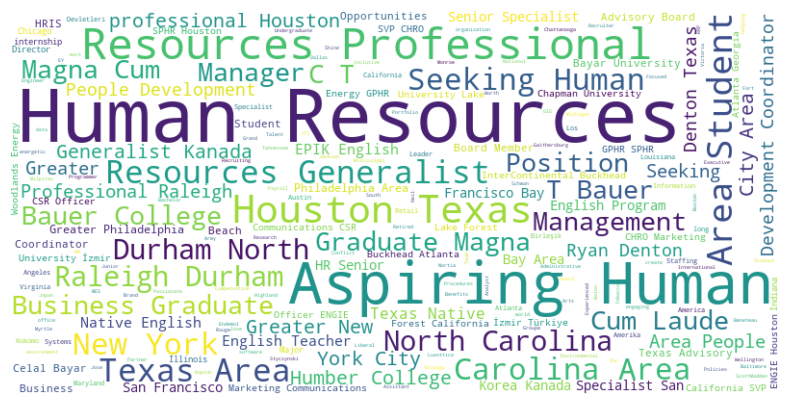

In [18]:
text = " ".join(df['job_title'])

# Create and configure the word cloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


### **Vectorization Methods**

##### Discussion regarding use of 'connections' feature

Before examining vectorization methods, it is important to have a discussion on how 'connections' feature can be used to create a 'fit_score'
- In this section, we use vectorization methods to find the vector embedding of 'job_title'. We then compare this embedding with that of the keyword argument using cosine comparison.
- Therefore, 'connections' (takes float values between 0 and 1) must also be incorporated into our methodology to produce a 'fit_score' for candidates. 

Intially, we thought about scaling all cosine comparison scores by 'connections' score. However, we realised this would place too much weight on connections. We found that the top of our list was over-dominated by people with 500 connections, regardless of how good of a fit they were for the job. For this reason, we thought of passing our 'connections' value through a logistic function:

$f(x) = \frac{1}{1+e^{-5x}}$

For $ 0 \leq x \leq 1$, $f(x)$ takes values between 0.5 and 0.993. This function has desirable properties. This function stays close to 0.5 for $x$ close to zero. Thus, this function correctly punishes individuals with very few connections (<50). However, the function increases to around 0.993 fairly quickly, flattening out around $x = 0.5$. Thus, individuals with more connections are benefitted, but individuals with 500 connections are not over-privileged too much. In other words, if someone has 250 or 500 connections, they will have a similar score according to this function. Therefore, the function is a checker to see if someone has 'some' connections. After passing 'connections' through this function, we then multiply the output by the cosine comparison score to obtain a final 'fit_score' value.

##### Evaluating Vectorization Methods

For each vectorization method output, we will rank the candidates by their corresponding 'fit_score'. We will then take the top 30 candidates from this list. We will then qualitatively assess the effectiveness of each vectorization method for the problem at hand.

##### TF-IDF

Below, we implement TF-IDF vectorization methods to achieve a final 'fit_score' for candidates, based on methods described previously. TF-IDF vectorization can be seen as the simplest or baseline methodology for finding vector embeddings of candidate titles. In TF-IDF, we attempt to understand how important a given word is relative to a whole collection of words (or corpus). In our case, the corpus is the list of all job titles plus our keyword. What sets TF-IDF apart from a simple word frequency, is that TF-IDF balances common and rare words to highlight the most important words.

In [8]:


# keyword phrase
keyword = "Aspiring human resources"

# combine candidate job titles with the keyword to form the corpus
# keyword is appended as the last document
corpus = df['job_title'].tolist() + [keyword]

# initialize TF-IDF Vectorizer and fit on the corpus
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(corpus)

# extract the keyword vector (last row) and candidate vectors (all rows except last)
keyword_vector = tfidf_matrix[-1]
candidate_vectors = tfidf_matrix[:-1]

# compute cosine similarity between each candidate's job title and the keyword
similarity_scores = cosine_similarity(candidate_vectors, keyword_vector)

df_tfidf = df.copy()

df_tfidf['tfidf_score'] = similarity_scores
# flatten the scores array and add it to the dataframe as the 'fit_score'
df_tfidf['fit_score'] = similarity_scores.flatten()*1 / (1 + np.exp(-5 * df['connection']))


Below, we show the top 30 candidates according to our 'fit_score'. We see that the candidates are generally quite a good fit for our keyword. We note that many of the candidates include the word 'aspiring' in their job title, and that many of the candidates are college students, who are looking for entry-level/internship roles, which fits with our keyword. Thus, we can say that the TF-IDF vectorization method performs quite well, yielding a fit_score which correctly finds individuals who are newly entering HR and looking for entry-level positions.

In [9]:
df_tfidf = df_tfidf.sort_values(by ='fit_score',ascending=False)
df_tfidf.head(30)

,id,job_title,connection,tfidf_score,fit_score
28,29,"Aspiring Human Resources Management student seeking an internship, Houston, Texas Area",1.000000,0.313836,0.311735
26,27,"Aspiring Human Resources Management student seeking an internship, Houston, Texas Area",1.000000,0.313836,0.311735
96,97,"Aspiring Human Resources Professional, Kokomo, Indiana Area",0.140281,0.382353,0.255602
72,73,"Aspiring Human Resources Manager, seeking internship in Human Resources., Houston, Texas Area",0.012024,0.476555,0.245438
24,25,"Student at Humber College and Aspiring Human Resources Generalist, Kanada",0.120240,0.367107,0.237126
49,50,"Student at Humber College and Aspiring Human Resources Generalist, Kanada",0.120240,0.367107,0.237126
51,52,"Student at Humber College and Aspiring Human Resources Generalist, Kanada",0.120240,0.367107,0.237126
38,39,"Student at Humber College and Aspiring Human Resources Generalist, Kanada",0.120240,0.367107,0.237126
36,37,"Student at Humber College and Aspiring Human Resources Generalist, Kanada",0.120240,0.367107,0.237126
6,7,"Student at Humber College and Aspiring Human Resources Generalist, Kanada",0.120240,0.367107,0.237126


### Word2Vec


Word2Vec attempts to gain vector representations/embeddings of words. Here, there is a focus on understanding the underlying semantics of words (i.e. which words go together, are similar to each other etc). Word2Vec is a family of models. Thus, there are many 'versions' of Word2Vec. Word2Vec uses a shallow neural network to learn word embeddings. It has two primary architectures:

- Continuous Bag-of-Words (CBOW): Predicts a target word based on its surrounding context words.
- Skip-Gram: Does the opposite by predicting surrounding context words given a target word.

The model learns by adjusting weights so that words appearing in similar contexts end up with similar vector representations. These vectors capture semantic relationships; for example, the vector difference between "king" and "queen" is similar to that between "man" and "woman". The output is a set of word vectors (embeddings), each typically of a fixed dimension (e.g., 100, 200, or 300). 

Here, we will first attempt to implement our own custom-trained Word2Vec Model using the 'job_title' column of data. We will then go through the same analysis of model results we did with TF-IDF. We then load a Word2Vec Model trained by Google, and examine it's performance on our data.


#### Custom-Trained Word2Vec Model 

In [16]:
corpus = df['job_title'].tolist()
processed_corpus = [simple_preprocess(text) for text in corpus]

# Train a Word2Vec model on your corpus
# Note: For robust embeddings, use a much larger corpus.
model = Word2Vec(sentences=processed_corpus, vector_size=100, window=5, min_count=1, workers=2, epochs=100)

# Define a helper function to get an average vector for a phrase
def get_phrase_vector(phrase, model):
    words = simple_preprocess(phrase)
    word_vectors = []
    for word in words:
        if word in model.wv:
            word_vectors.append(model.wv[word])
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        # Return a zero vector if none of the words are in the vocabulary
        return np.zeros(model.vector_size)

# Define your keyword phrase
keyword = "Aspiring human resources"
keyword_vec = get_phrase_vector(keyword, model)

# Compute cosine similarity for each candidate
fit_scores = []
for title in df['job_title']:
    title_vec = get_phrase_vector(title, model)
    # Reshape vectors to 2D arrays for cosine_similarity
    sim = cosine_similarity([title_vec], [keyword_vec])[0][0]
    fit_scores.append(sim)

# Add the fit scores to the dataframe
df_word2vec_custom = df.copy()

df_word2vec_custom['word2vec_score'] = fit_scores


df_word2vec_custom['fit_score'] = fit_scores*1 / (1 + np.exp(-5 * df['connection']))

df_word2vec_custom = df_word2vec_custom.sort_values(by ='fit_score',ascending=False)
df_word2vec_custom.head(30)

,id,job_title,connection,word2vec_score,fit_score
66,67,"Human Resources, Staffing and Recruiting Professional, Jackson, Mississippi Area",1.000000,0.972395,0.965886
52,53,"Seeking Human Resources HRIS and Generalist Positions, Greater Philadelphia Area",1.000000,0.969941,0.963449
9,10,"Seeking Human Resources HRIS and Generalist Positions, Greater Philadelphia Area",1.000000,0.969941,0.963449
39,40,"Seeking Human Resources HRIS and Generalist Positions, Greater Philadelphia Area",1.000000,0.969941,0.963449
61,62,"Seeking Human Resources HRIS and Generalist Positions, Greater Philadelphia Area",1.000000,0.969941,0.963449
28,29,"Aspiring Human Resources Management student seeking an internship, Houston, Texas Area",1.000000,0.962436,0.955995
26,27,"Aspiring Human Resources Management student seeking an internship, Houston, Texas Area",1.000000,0.962436,0.955995
100,101,"Human Resources Generalist at Loparex, Raleigh-Durham, North Carolina Area",1.000000,0.958322,0.951908
70,71,"Human Resources Generalist at ScottMadden, Inc., Raleigh-Durham, North Carolina Area",1.000000,0.954900,0.948509
68,69,"Director of Human Resources North America, Groupe Beneteau, Greater Grand Rapids, Michigan Area",1.000000,0.951893,0.945523


Above, we have shown the top 30 individuals according to 'fit_score'. Generally, we can say that the model appears to find candidates who are slightly overqualified for an 'aspiring human resources' position. Thus, although the model does well to find individuals who are involved with HR, it doesn't find enough individuals who are seeking more entry-level positions.  

In [17]:
# assign ranks to candidates based on fit_score
df_word2vec_custom['rank'] = df_word2vec_custom['fit_score'].rank(method='dense', ascending=False).astype(int)
score_ranks_word2vec_custom = df_word2vec_custom.head(30)['rank'].values

#### Google Trained Word2Vec Model

Below, we examine results produced by a Word2Vec model trained by Google.

In [16]:
import gensim.downloader as api

# Load the pre-trained Word2Vec model from Google News, 300 dimensions
wv = api.load('word2vec-google-news-300')


[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:


# Function to compute the average vector for a phrase
def get_phrase_vector(phrase, model):
    words = simple_preprocess(phrase)
    word_vectors = [model[word] for word in words if word in model]
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        # Return a zero vector if none of the words are in the vocabulary
        return np.zeros(model.vector_size)

# Define your keyword phrase
keyword = "Aspiring human resources"
keyword_vec = get_phrase_vector(keyword, wv)

# Compute cosine similarity for each candidate job title
fit_scores = []
for title in df['job_title']:
    title_vec = get_phrase_vector(title, wv)
    # Ensure we have valid vectors before computing similarity
    sim = cosine_similarity([title_vec], [keyword_vec])[0][0]
    fit_scores.append(sim)

# Add the similarity scores to the dataframe
# Add the fit scores to the dataframe
df_word2vec_google = df.copy()


df_word2vec_google['word2vec_score'] = fit_scores
df_word2vec_google.to_csv("word2vec_300_results")


Below, we see the 30 best individuals according to our 'fit_score'. We see that, compared to our custom-trained word2vec vectorizer, this vectorizer yields many more individuals who are seeking more entry-level positions. Furthermore, this list mostly contains individuals who are actively seeking a job in HR, which is good. However, our list below also contains many individuals who are too experienced for an aspiring HR role.

In [21]:
df_word2vec_google = pd.read_csv("word2vec_300_results.csv", index_col=0)

df_word2vec_google['fit_score'] = df_word2vec_google["word2vec_score"]*1 / (1 + np.exp(-5 * df_word2vec_google['connection']))

df_word2vec_google = df_word2vec_google.sort_values(by ='fit_score',ascending=False)
df_word2vec_google.head(30)

,id,job_title,connection,word2vec_score,fit_score
77,78,"Human Resources Generalist at Schwan's, Amerika Birleşik Devletleri",1.000000,0.747326,0.742324
26,27,"Aspiring Human Resources Management student seeking an internship, Houston, Texas Area",1.000000,0.652555,0.648187
28,29,"Aspiring Human Resources Management student seeking an internship, Houston, Texas Area",1.000000,0.652555,0.648187
9,10,"Seeking Human Resources HRIS and Generalist Positions, Greater Philadelphia Area",1.000000,0.629139,0.624928
61,62,"Seeking Human Resources HRIS and Generalist Positions, Greater Philadelphia Area",1.000000,0.629139,0.624928
39,40,"Seeking Human Resources HRIS and Generalist Positions, Greater Philadelphia Area",1.000000,0.629139,0.624928
52,53,"Seeking Human Resources HRIS and Generalist Positions, Greater Philadelphia Area",1.000000,0.629139,0.624928
66,67,"Human Resources, Staffing and Recruiting Professional, Jackson, Mississippi Area",1.000000,0.606997,0.602935
80,81,"Senior Human Resources Business Partner at Heil Environmental, Chattanooga, Tennessee Area",0.909820,0.605120,0.598787
93,94,"Seeking Human Resources Opportunities. Open to travel and relocation., Amerika Birleşik Devletleri",0.829659,0.600015,0.590687


#### GloVe

Instead of using a sliding window approach like Word2Vec, GloVe leverages the global word-word co-occurrence matrix computed over a large corpus. This matrix captures how frequently pairs of words appear together in the corpus. GloVe performs a weighted factorization of this co-occurrence matrix to produce word vectors. The idea is that the ratios of co-occurrence probabilities between words can encode meaningful semantic relationships.

Here, we will use a pre-trained model from Stanford. We will use gensim to convert the GloVe vectors into word2vec.




In [9]:
!powershell -Command "Invoke-WebRequest -Uri 'http://nlp.stanford.edu/data/glove.6B.zip' -OutFile 'glove.6B.zip'"
!powershell -Command "Expand-Archive -Path 'glove.6B.zip' -DestinationPath '.'"

In [10]:
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
import os

# Specify the path to your GloVe file (e.g., 100d vectors)
glove_input_file = 'glove.6B.100d.txt'
word2vec_output_file = 'glove.6B.100d.word2vec.txt'

# Convert GloVe file to word2vec format if not already done
if not os.path.exists(word2vec_output_file):
    glove2word2vec(glove_input_file, word2vec_output_file)

# Load the converted embeddings
glove_model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)


C:\Users\shann\AppData\Local\Temp\ipykernel_16100\3249346831.py:11: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input_file, word2vec_output_file)


In [ ]:
# Function to compute the average vector for a phrase
def get_phrase_vector(phrase, model):
    words = simple_preprocess(phrase)
    word_vectors = []
    for word in words:
        if word in model:
            word_vectors.append(model[word])
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        # Return a zero vector if none of the words are in the model's vocabulary
        return np.zeros(model.vector_size)

# Define your keyword phrase
keyword = "Aspiring human resources"
keyword_vec = get_phrase_vector(keyword, glove_model)

# Compute cosine similarity for each candidate job title
fit_scores = []
for title in df['job_title']:
    title_vec = get_phrase_vector(title, glove_model)
    sim = cosine_similarity([title_vec], [keyword_vec])[0][0]
    fit_scores.append(sim)

# Add the fit scores to the dataframe
df_glove = df.copy()

df_glove['glove_score'] = fit_scores
df_glove.to_csv("glove_100_results")

Below show the top 30 candidates according to our 'fit_score'. We see that the list below contains relatively few individuals who are seeking entry-level HR positions. Many of the individuals below are either overqualified and/or not actively seeking a role. It appears that GloVe performs significantly worse than TF-IDF or the google trained Word2Vec models for our present problem.

In [12]:
df_glove = pd.read_csv("glove_100_results.csv",index_col=0)

df_glove['fit_score'] = df_glove['glove_score']*1 / (1 + np.exp(-5 * df['connection']))

df_glove = df_glove.sort_values(by ='fit_score',ascending=False)
df_glove.head(30)

,id,job_title,connection,glove_score,fit_score
52,53,"Seeking Human Resources HRIS and Generalist Positions, Greater Philadelphia Area",1.000000,0.816495,0.811030
9,10,"Seeking Human Resources HRIS and Generalist Positions, Greater Philadelphia Area",1.000000,0.816495,0.811030
39,40,"Seeking Human Resources HRIS and Generalist Positions, Greater Philadelphia Area",1.000000,0.816495,0.811030
61,62,"Seeking Human Resources HRIS and Generalist Positions, Greater Philadelphia Area",1.000000,0.816495,0.811030
29,30,"Seeking Human Resources Opportunities, Chicago, Illinois",0.779559,0.826828,0.810388
27,28,"Seeking Human Resources Opportunities, Chicago, Illinois",0.779559,0.826828,0.810388
26,27,"Aspiring Human Resources Management student seeking an internship, Houston, Texas Area",1.000000,0.803606,0.798227
28,29,"Aspiring Human Resources Management student seeking an internship, Houston, Texas Area",1.000000,0.803606,0.798227
93,94,"Seeking Human Resources Opportunities. Open to travel and relocation., Amerika Birleşik Devletleri",0.829659,0.799597,0.787167
66,67,"Human Resources, Staffing and Recruiting Professional, Jackson, Mississippi Area",1.000000,0.779724,0.774506


#### fastText

fastText is an extension of word embedding techniques. It improves upon traditional methods like Word2Vec by incorporating subword (character n-gram) information into the embeddings. This allows fastText to produce more robust representations, especially for rare or misspelled words, by capturing internal word structure.

Below, we implement a fastText vectorizer method, which has dimension 300 and which is trained on wikipedia text. 




In [17]:
import gensim.downloader as api

# Download and load the pre-trained fastText model
ft_model = api.load("fasttext-wiki-news-subwords-300")


[==================================================] 100.0% 958.5/958.4MB downloaded


In [ ]:
def get_phrase_vector(phrase, model):
    words = phrase.lower().split()
    # Use model[word] directly because ft_model is a KeyedVectors instance.
    word_vectors = [model[word] for word in words if word in model]
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

keyword = "aspiring human resources"
keyword_vec = get_phrase_vector(keyword, ft_model)

# Compute cosine similarity for each candidate job title
fit_scores = []
for title in df['job_title']:
    title_vec = get_phrase_vector(title, ft_model)
    # Ensure we have valid vectors before computing similarity
    sim = cosine_similarity([title_vec], [keyword_vec])[0][0]
    fit_scores.append(sim)

# Add the similarity scores to the dataframe
df_fasttext = df.copy()
df_fasttext['fasttext_score'] = fit_scores

# 'connection' scaling 
df_fasttext['fit_score'] = df_fasttext["fasttext_score"] * 1 / (1 + np.exp(-5 * df_fasttext['connection']))

df_fasttext = df_fasttext.sort_values(by='fit_score', ascending=False)
df_fasttext.to_csv("fasttext_300_results.csv", index=False)



Below, we can see the top 30 candidates according to our 'fit_score'. We can see that, while the top half of the list is generally good, the bottom half contains many individuals who are not actively seeking HR roles and/or too overqualified for 'aspiring HR' roles. Thus, we can see that this fastText model performs fairly well, but not brilliantly at the task at hand.

In [13]:
df_fasttext = pd.read_csv("fasttext_300_results.csv",index_col=0)


df_glove.head(30)

,id,job_title,connection,glove_score,fit_score
52,53,"Seeking Human Resources HRIS and Generalist Positions, Greater Philadelphia Area",1.000000,0.816495,0.811030
9,10,"Seeking Human Resources HRIS and Generalist Positions, Greater Philadelphia Area",1.000000,0.816495,0.811030
39,40,"Seeking Human Resources HRIS and Generalist Positions, Greater Philadelphia Area",1.000000,0.816495,0.811030
61,62,"Seeking Human Resources HRIS and Generalist Positions, Greater Philadelphia Area",1.000000,0.816495,0.811030
29,30,"Seeking Human Resources Opportunities, Chicago, Illinois",0.779559,0.826828,0.810388
27,28,"Seeking Human Resources Opportunities, Chicago, Illinois",0.779559,0.826828,0.810388
26,27,"Aspiring Human Resources Management student seeking an internship, Houston, Texas Area",1.000000,0.803606,0.798227
28,29,"Aspiring Human Resources Management student seeking an internship, Houston, Texas Area",1.000000,0.803606,0.798227
93,94,"Seeking Human Resources Opportunities. Open to travel and relocation., Amerika Birleşik Devletleri",0.829659,0.799597,0.787167
66,67,"Human Resources, Staffing and Recruiting Professional, Jackson, Mississippi Area",1.000000,0.779724,0.774506


### Transformers



Below, we implement the BERT encoder. BERT (Bidirectional Encoder Representations from Transformers) is a pre-trained transformer model designed to understand the context of words in a sentence by looking at both their left and right context. Here, we only use BERT to encode our 'job_description'.

In [ ]:
from sentence_transformers import SentenceTransformer, util


# Load a pre-trained SentenceTransformer model
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Define your keyword
keyword = "aspiring human resources"

# Encode the keyword and candidate job titles
keyword_embedding = model.encode(keyword, convert_to_tensor=True)
job_title_embeddings = model.encode(df['job_title'].tolist(), convert_to_tensor=True)

# Compute cosine similarity between each job title and the keyword
cosine_scores = util.cos_sim(job_title_embeddings, keyword_embedding)

# Convert cosine_scores to a numpy array and flatten it
fit_scores = cosine_scores.cpu().numpy().flatten()

# Add the similarity scores to the dataframe
df_bert = df.copy()

df_bert['transformer_score'] = fit_scores

# 'connection' scaling 
df_bert['fit_score'] = df_bert['transformer_score'] /(1 + np.exp(-5 * df_bert['connection']))

# Sort candidates by final fit score
df_bert = df_bert.sort_values(by='fit_score', ascending=False)
print(df_bert.head())


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

c:\Users\shann\OneDrive\Documents OneDrive Personal\apziva\project_3\myenv\Lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\shann\.cache\huggingface\hub\models--sentence-transformers--paraphrase-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.51k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

      id                                          job_title  connection  \
27    28  Seeking Human Resources Opportunities, Chicago...    0.779559   
29    30  Seeking Human Resources Opportunities, Chicago...    0.779559   
28    29  Aspiring Human Resources Management student se...    1.000000   
26    27  Aspiring Human Resources Management student se...    1.000000   
52    53  Seeking Human Resources HRIS and Generalist Po...    1.000000   
..   ...                                                ...         ...   
97    98                       Student, Houston, Texas Area    0.006012   
90    91  Lead Official at Western Illinois University, ...    0.076152   
86    87  Bachelor of Science in Biology from Victoria U...    0.078156   
101  102  Business Intelligence and Analytics at Travele...    0.096192   
92    93  Admissions Representative at Community medical...    0.016032   

     transformer_score  fit_score  
27            0.682205   0.668640  
29            0.682205   0.

Below, we see the top 30 individuals according to 'fit_score'. Generally, we see that most candidates are aspiring/acitively seeking HR roles. Thereofore our list is generally quite good. There are only 2-3 individuals in the whole list who are not actively seeking and/or overqualified for an apsiring HR role. Therefore, the BERT encoder works well for the task at hand.

In [14]:
df_bert = pd.read_csv("bert_results.csv",index_col=0)


df_bert.head(30)

,job_title,connection,transformer_score,fit_score
id,,,,
28,"Seeking Human Resources Opportunities, Chicago, Illinois",0.779559,0.682205,0.668640
30,"Seeking Human Resources Opportunities, Chicago, Illinois",0.779559,0.682205,0.668640
29,"Aspiring Human Resources Management student seeking an internship, Houston, Texas Area",1.000000,0.647703,0.643368
27,"Aspiring Human Resources Management student seeking an internship, Houston, Texas Area",1.000000,0.647703,0.643368
53,"Seeking Human Resources HRIS and Generalist Positions, Greater Philadelphia Area",1.000000,0.628871,0.624662
62,"Seeking Human Resources HRIS and Generalist Positions, Greater Philadelphia Area",1.000000,0.628871,0.624662
40,"Seeking Human Resources HRIS and Generalist Positions, Greater Philadelphia Area",1.000000,0.628871,0.624662
10,"Seeking Human Resources HRIS and Generalist Positions, Greater Philadelphia Area",1.000000,0.628871,0.624662
82,"Aspiring Human Resources Professional | An energetic and Team-Focused Leader, Austin, Texas Area",0.346693,0.728840,0.619408


##### Evaluation of vectorization methods

In this section of our project, we have qualititatively evaluated the effectiveness of different word vectorization methods. We found that TF-IDF, Word2Vec and BERT encoders worked the best at identifying individuals actively seeking entry-level roles, using the keyword 'aspiring human resources'.

In the next section, we will manually correct our results from the TF-IDF embedding, promoting a few individuals to higher scores if we believe they deserve this. We will then use this corrected ranking to train a pairwise learn-to-rank model. Here, we have decided to work with the results from the TF-IDF vectorizer as it has good results, and it is computationally very inexpensive to run.

### Learn-to-rank models

Learn-to-Rank (LTR) refers to a class of machine learning techniques designed to automatically learn ranking functions from data. LTR focuses on optimizing the relative ordering of items, making it well-suited for search and recommendation systems. In the context of this project, LTR is used to rank job candidates based on their 'fit_score' from our previous investigations of vector embedding techniques. In this project we will implement a pairwise learn-to-rank model. Before we do this, we must double check our top 30 candidate ranking and make any corrections we see fit.



##### Manual Changes to TF-IDF Results

Below, generally the list of individuals is quite good. The only recommendation that could be made would be to promote the last 3 individuals to higher positions (assign a fit_score of 0.3), as these individuals are Magna Cum Laude students. 

In [15]:
df_tfidf.head(30)

,id,job_title,connection,tfidf_score,fit_score
28,29,"Aspiring Human Resources Management student seeking an internship, Houston, Texas Area",1.000000,0.313836,0.311735
26,27,"Aspiring Human Resources Management student seeking an internship, Houston, Texas Area",1.000000,0.313836,0.311735
96,97,"Aspiring Human Resources Professional, Kokomo, Indiana Area",0.140281,0.382353,0.255602
72,73,"Aspiring Human Resources Manager, seeking internship in Human Resources., Houston, Texas Area",0.012024,0.476555,0.245438
24,25,"Student at Humber College and Aspiring Human Resources Generalist, Kanada",0.120240,0.367107,0.237126
49,50,"Student at Humber College and Aspiring Human Resources Generalist, Kanada",0.120240,0.367107,0.237126
51,52,"Student at Humber College and Aspiring Human Resources Generalist, Kanada",0.120240,0.367107,0.237126
38,39,"Student at Humber College and Aspiring Human Resources Generalist, Kanada",0.120240,0.367107,0.237126
36,37,"Student at Humber College and Aspiring Human Resources Generalist, Kanada",0.120240,0.367107,0.237126
6,7,"Student at Humber College and Aspiring Human Resources Generalist, Kanada",0.120240,0.367107,0.237126


In [20]:
id_promoted = [44,31,1]

df_tfidf.loc[df_tfidf['id'].isin(id_promoted), 'fit_score'] = 0.3
df_tfidf = df_tfidf.sort_values(by='fit_score', ascending=False)

We now add a 'rank' score to our individuals, which is found using a dense-ranking method in descending order.

In [22]:
df_tfidf['rank'] = df_tfidf['fit_score'].rank(method='dense', ascending=False).astype(int)


#### Pairwise LTR (RankNet)

Pairwise LTR approaches model the relative preference between pairs of items rather than evaluating individual items in isolation. The core idea is to train the model to predict which item in a pair should be ranked higher for a given query. This is particularly useful when it is easier to obtain or infer relative preferences (e.g., "candidate A is more suitable than candidate B") rather than absolute relevance scores.

RankNet is a foundational pairwise LTR model developed by Microsoft Research. It uses a neural network to estimate a scoring function that maps a query-item pair to a real-valued score. During training, for each pair of candidates associated with a job keyword, the model learns to assign a higher score to the more relevant candidate. 

In [23]:


# ---------------------------
# Dataset Preparation
# ---------------------------
class RankingDataset(Dataset):
    def __init__(self, features, ranks):
        """
        features: np.array of shape (N, d) where N is the number of candidates
        ranks: np.array of shape (N,), with lower numbers indicating better ranks
        """
        self.features = features
        self.ranks = ranks
        self.pairs = []
        self.labels = []
        N = len(ranks)
        # Create all candidate pairs with different ranks
        for i in range(N):
            for j in range(i+1, N):
                if self.ranks[i] != self.ranks[j]:
                    # Label is 1 if candidate i should be ranked higher (i.e. has a lower rank number)
                    label = 1 if self.ranks[i] < self.ranks[j] else 0
                    self.pairs.append((i, j))
                    self.labels.append(label)
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        i, j = self.pairs[idx]
        label = self.labels[idx]
        # Return features for candidate i and candidate j, and the pairwise label
        x_i = self.features[i]
        x_j = self.features[j]
        return torch.tensor(x_i, dtype=torch.float32), torch.tensor(x_j, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)

# ---------------------------
# Model Definition
# ---------------------------
class RankNet(nn.Module):
    def __init__(self, input_dim):
        super(RankNet, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)  # Output a single score
        )
    
    def forward(self, x):
        return self.fc(x)

# ---------------------------
# Pairwise Loss Function (RankNet loss)
# ---------------------------
def pairwise_loss(s_i, s_j, label):
    """
    s_i: Predicted score for candidate i.
    s_j: Predicted score for candidate j.
    label: 1 if candidate i should be ranked higher than candidate j, else 0.
    """
    # Compute the difference in scores
    diff = s_i - s_j
    # Convert to a probability using the sigmoid function
    prob = torch.sigmoid(diff)
    # Compute binary cross entropy loss
    loss = nn.BCELoss()(prob, label)
    return loss


# convert job descriptions into numerical features using TF-IDF
tfidf = TfidfVectorizer(max_features=1000)
X_text = tfidf.fit_transform(df_tfidf["job_title"])

# prepare the 'connections' feature (reshape it to a 2D array)
X_connections = np.array(df_tfidf["connection"]).reshape(-1, 1)

# combine the TF-IDF features with the 'connections' feature
features = hstack([X_text, X_connections])
features = features.toarray()  # Convert the sparse matrix to a dense NumPy array

feature_dim = features.shape[1]

ranks = df_tfidf["rank"].values

# ---------------------------
# Train-Test Split
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(features, ranks, test_size=0.2, random_state=42)

# Create RankingDataset for training and test data
train_dataset = RankingDataset(X_train, y_train)
test_dataset  = RankingDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)

# ---------------------------
# Training the Model
# ---------------------------
model = RankNet(input_dim=feature_dim)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 100
loss_history = np.zeros(epochs)
for epoch in range(epochs):
    total_loss = 0.0
    model.train()  # Make sure model is in training mode
    for x_i, x_j, label in train_loader:
        optimizer.zero_grad()
        # Get scores for both candidates in the pair
        s_i = model(x_i).squeeze()  # shape: (batch_size,)
        s_j = model(x_j).squeeze()
        loss = pairwise_loss(s_i, s_j, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)

    loss_history[epoch] = avg_loss


Below, we plot the loss function of the model over epochs. We can clearly see that the loss function plateaus nicely, close to zero. 

In [24]:
import plotly.express as px
df_loss = pd.DataFrame({
    "Epoch": list(range(1, len(loss_history) + 1)),
    "Loss": loss_history
})

# Create an interactive line plot using Plotly Express
fig = px.line(df_loss, x="Epoch", y="Loss", title="Training Loss per Epoch", markers=True)
fig.show()


Below, we calculate the pairwise accuracy of our model output on the test dataset. We can clearly see that the model performs quite well (93.5% accuracy). 

In [25]:
# ---------------------------
# Evaluation: Compute Pairwise Accuracy on Test Set
# ---------------------------
def compute_pairwise_accuracy(model, dataloader):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for x_i, x_j, label in dataloader:
            s_i = model(x_i).squeeze()
            s_j = model(x_j).squeeze()
            # Predict 1 if candidate i's score is higher than candidate j's score
            pred_label = (s_i > s_j).float()
            correct += (pred_label == label).sum().item()
            total += label.size(0)
    accuracy = correct / total if total > 0 else 0
    return accuracy

test_accuracy = compute_pairwise_accuracy(model, test_loader)
print("Test Pairwise Accuracy: {:.2%}".format(test_accuracy))


Test Pairwise Accuracy: 93.53%


### Conclusion and Evaluation

In this project we were tasked with automatizing an HR recruitment agency's method for ranking relevance of candidates for a given job keyword. To this end, we first examined the relative performance of different vector embedding methods. We found that the TF-IDF, google-trained Word2Vec, and BERT encoder performed the best a candidate's job title with a given job keyword. 

We then examined implementing LTR Models based on the TF-IDF vector embeddings and relative 'fit_scores' of the candidates. More specifically, we implemented a RankNet pairwise model. We found that our model trained well, with a smooth loss function, and performed well according to the pairwise accuracy on our test dataset (93.5% accuracy). 

One obvious strength of our model is its relatively low computational complexity. The TF-IDF vectorization method is computationally inexpensive, as is a pairwise learn-to-rank method. Therefore, our model can be quite quickly trained and implemented for any given keyword. That said, before going forward with implementing our model in an industry-level setting, it would be wise to re-implement it with a larger dataset. The dataset we were given is quite small and includes many duplicate individuals. Therefore, it would be advantageous to re-run our models with a larger and more varied dataset. 

##### References

https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html

https://www.geeksforgeeks.org/n-gram-language-modelling-with-nltk/

https://www.coveo.com/blog/word2vec-explained/

https://jonathan-hui.medium.com/nlp-word-embedding-glove-5e7f523999f6

https://www.datacamp.com/tutorial/how-transformers-work

https://nlp.seas.harvard.edu/2018/04/03/attention.html

https://arxiv.org/pdf/2311.17633